## Лабораторная 5: логистическая регрессия. ROC. AUC. One-hot encoding

## 1
Рассмотрим данные медицинской страховой фирмы. На основе характеристик пациентов `Members.csv` (возраст, пол) и данных о получении медицинского обслуживания в предыдущем году `Claims_Y1.csv` (медицинское учреждение, врач, тип проблемы, количество дней госпитализации, дата, и др. ) нужно предсказать факт госпитализации хотя бы на 1 день в следующем году `DaysInHospital_Y2.csv`.

In [15]:
import pandas as pd

from sklearn import *

%matplotlib inline
import matplotlib.pyplot as plt

Прочтите данные, в качестве параметра index_col используйте `MemberID`. 

* данные из таблицы 'DaysInHospital_Y2.csv' в переменную `days2`
* данные из таблицы 'Members.csv' в переменную `m`
* данные из таблицы 'Claims_Y1.csv' в переменную `claims`

In [16]:
days2 = pd.read_csv('DaysInHospital_Y2.csv', index_col = (['MemberID']))
m = pd.read_csv('Members.csv', index_col = (['MemberID']))
claims = pd.read_csv('Claims_Y1.csv', index_col = (['MemberID']))
print(days2)
print(m)
print(claims)

          ClaimsTruncated  DaysInHospital
MemberID                                 
98324177                0               0
33899367                1               1
5481382                 0               1
69908334                0               0
29951458                0               0
...                   ...             ...
1702326                 0               0
31530440                0               0
87102780                0               0
74032946                0               0
21964521                0               0

[76037 rows x 2 columns]
         AgeAtFirstClaim Sex
MemberID                    
14723353           70-79   M
75706636           70-79   M
17320609           70-79   M
69690888           40-49   M
33004608             0-9   M
...                  ...  ..
99711514           40-49   F
31690877           50-59   F
9519985            30-39   F
92806272           50-59   F
81827173           40-49   F

[113000 rows x 2 columns]
          ProviderID    

## 2
Чтобы анонимизировать данные организатор указал приблизительную информацию о пациентах, например в столбце возраст указаны возрастные группы: '0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+'. Преобразуем строковые признаки в количественные и заменим пропущенные значения:

In [17]:
i = pd.notnull(m.AgeAtFirstClaim)
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: s.split('-')[0] if s!='80+' else '80')
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: int(s))

m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)

m.Sex = m.Sex.fillna(value='N')

claims.CharlsonIndex = claims.CharlsonIndex.map({'0':0, '1-2':1, '3-4':3, '5+':5})
claims.LengthOfStay = claims.LengthOfStay.fillna(value=0)
claims.LengthOfStay = claims.LengthOfStay.map({0:0, '1 day':1, '2 days':2, '3 days':3, '4 days':4,\
    '5 days':5, '6 days':6, '1- 2 weeks':10, '2- 4 weeks':21, '4- 8 weeks':42, '26+ weeks':182})
print(claims)

          ProviderID    Vendor      PCP Year           Specialty  \
MemberID                                                           
42286978   8013252.0  172193.0  37796.0   Y1             Surgery   
99829076   6721023.0  265273.0  91972.0   Y1      Rehabilitation   
54666321   9932074.0   35565.0  27294.0   Y1  Diagnostic Imaging   
66951188   4699470.0  179509.0  75876.0   Y1  Diagnostic Imaging   
78859054   9121540.0  523791.0  21579.0   Y1           Emergency   
...              ...       ...      ...  ...                 ...   
98535515   7638907.0  559727.0  83829.0   Y1           Emergency   
1344508    4107701.0  164823.0  78718.0   Y1          Laboratory   
73820095   1256697.0  789572.0    821.0   Y1             Surgery   
22476463   7053364.0  240043.0  70171.0   Y1          Laboratory   
57805129   3884005.0  523319.0  90756.0   Y1            Internal   

                    PlaceSvc PayDelay  LengthOfStay         DSFS  \
MemberID                                       

## 3
Сконструируем признаки по массиву случаев медицинского обслуживания: 
* `f_Charlson` — максимальный индекс коморбидности Чальсона по всем случаям для пациента (`CharlsonIndex` в таблице `claims`)
* `f_LengthOfStay` — суммарное количество дней госпитализации в прошлом году (`LengthOfStay` в таблице `claims`) 

*Функции, которые могут пригодиться при решении: `.groupby(['MemberID']), .max(), .sum()`* 

In [18]:
f_Charlson = claims['CharlsonIndex'].groupby(['MemberID']).max()
f_LengthOfStay = claims['LengthOfStay'].groupby(['MemberID']).sum()
print(f_Charlson, '\n')
print(f_LengthOfStay)

MemberID
210         0
3197        0
3889        1
4187        0
9063        0
           ..
99995554    0
99996214    0
99997485    0
99997895    0
99998627    1
Name: CharlsonIndex, Length: 76038, dtype: int64 

MemberID
210         2
3197        0
3889        3
4187        0
9063        0
           ..
99995554    0
99996214    0
99997485    0
99997895    0
99998627    2
Name: LengthOfStay, Length: 76038, dtype: int64


## 4

Составим матрицу объектов признаков со столбцами: `f_Charlson`, `f_LengthOfStay`, возраст пациента, `ClaimsTruncated` (не оказалось ли случаев медицинского обслуживания слишком много):

*Функции, которые могут пригодиться при решении: `.join()`*

In [19]:
data = days2
data = data.join(f_Charlson)
data = data.join(f_LengthOfStay)
# место для кода
data.head(15)

,ClaimsTruncated,DaysInHospital,CharlsonIndex,LengthOfStay
MemberID,,,,
98324177,0,0,0,0
33899367,1,1,0,0
5481382,0,1,0,0
69908334,0,0,0,0
29951458,0,0,0,0
8169687,0,0,1,0
51315613,0,0,0,0
45622725,0,0,0,0
56804176,0,0,0,0


## 5
Составим функцию, которая будет делить выборку на две части `dataTrain` и `dataTest`, обучать логистическую регрессию на `dataTrain`, применять к `dataTest`, строить кривую ошибок и считать под ней площадь:

In [20]:
def calcAUC(data):
    dataTrain, dataTest = model_selection.train_test_split(data, test_size=0.5, random_state=1)
    model = linear_model.LogisticRegression()
    model.fit( dataTrain.loc[:, dataTrain.columns != 'DaysInHospital'], dataTrain.DaysInHospital )
    predictionProb = model.predict_proba( dataTest.loc[:, dataTest.columns != 'DaysInHospital'] )
    fpr, tpr, _ = metrics.roc_curve(dataTest['DaysInHospital'], predictionProb[:,1])
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.show()
    print( metrics.roc_auc_score(dataTest['DaysInHospital'], predictionProb[:,1]) )

## 6
Применим данную функцию к `data`:

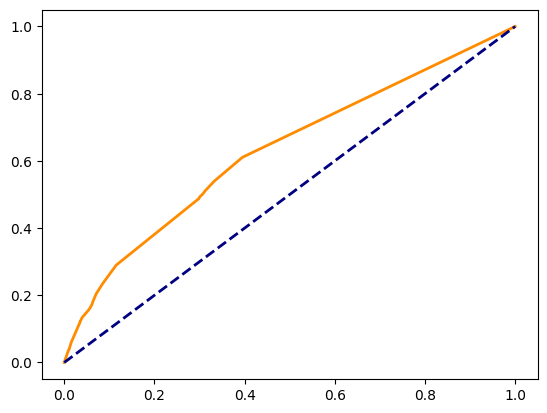

0.6307469087049324


In [21]:
calcAUC(data)

## 7
Логистическая регрессия принимает на вход только количественные признаки.

Добавим к нашим данным пол пациента, применив one hot encoding:

*Функции, которые могут пригодиться при решении: `pd.get_dummies(m.Sex, prefix='pol')`* 

In [22]:
pd.get_dummies(m.Sex, prefix='pol')
data = data.join(pd.get_dummies(m.Sex, prefix='pol'))
data

,ClaimsTruncated,DaysInHospital,CharlsonIndex,LengthOfStay,pol_F,pol_M,pol_N
MemberID,,,,,,,
98324177,0,0,0,0,0,1,0
33899367,1,1,0,0,1,0,0
5481382,0,1,0,0,1,0,0
69908334,0,0,0,0,1,0,0
29951458,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
1702326,0,0,0,0,0,0,1
31530440,0,0,0,0,0,1,0
87102780,0,0,0,0,1,0,0


## 8
Попытайтесь применить  one hot encoding к уже существующим в `data2` признакам или составить новые признаки по массиву `claims`.

In [23]:
data2 = data
data2 = data2.join(pd.get_dummies(claims.Year, prefix='f_Charlson'))
data2

,ClaimsTruncated,DaysInHospital,CharlsonIndex,LengthOfStay,pol_F,pol_M,pol_N,f_Charlson_Y1
MemberID,,,,,,,,
210,0,0,0,2,0,0,1,1
210,0,0,0,2,0,0,1,1
210,0,0,0,2,0,0,1,1
210,0,0,0,2,0,0,1,1
210,0,0,0,2,0,0,1,1
...,...,...,...,...,...,...,...,...
99998627,0,0,1,2,1,0,0,1
99998627,0,0,1,2,1,0,0,1
99998627,0,0,1,2,1,0,0,1


Построить матрицу объектов признаков, для которой логистическая регрессия работает с наилучшим качеством:

In [24]:
data2

,ClaimsTruncated,DaysInHospital,CharlsonIndex,LengthOfStay,pol_F,pol_M,pol_N,f_Charlson_Y1
MemberID,,,,,,,,
210,0,0,0,2,0,0,1,1
210,0,0,0,2,0,0,1,1
210,0,0,0,2,0,0,1,1
210,0,0,0,2,0,0,1,1
210,0,0,0,2,0,0,1,1
...,...,...,...,...,...,...,...,...
99998627,0,0,1,2,1,0,0,1
99998627,0,0,1,2,1,0,0,1
99998627,0,0,1,2,1,0,0,1
